In [ ]:
#! /usr/bin/env nix-shell
#! nix-shell -i python3 -p python3Packages.requests

import datetime
import json
import time
from typing import Literal, Union

import requests

LAST = 4154
SLEEP = 0.1 # 0.1 = 1s, limite legerement en dessous de 1s

def main(
    querying: Union[Literal["cpu"], Literal["gpu"]],
    filename: str,
    last_id: int,
    sleep_time: float = 1,
):
    """Make an API call every `sleep_time` (in seconds) and save the aggregated JSON to `{filename}_{current_time}.json`."""

    credentials = {
        "api_key": "1_oZWfpb7IQ05lF9iKPMExhQHxz4BoVrucc74NPiBJYZIBOu1ZhHbwJApZeQq1x7SBWutYSFEbwvXW5xiR0BJwwdzIYHmXGPGY1a82U0CQWs6hCzQ92lvqIUXjJjumXrF3"
    }
    result = []

    print(f"querying {querying}")

    try:
        for id in range(1, last_id + 1):
            r = requests.get(
                f"https://fr.gamesplanet.com/api/v1/techs/{querying}_details/{id}",
                params=credentials,
            )

            response = r.json()
            if response["status"] == "success":
                print(f"id {id}: success")
                result.append(response["result"])

            time.sleep(sleep_time)
    finally:
        print("writing")
        now = "2025-09-24"
        with open(f"{filename}_{now}.json", "w") as file:
            json.dump(result, file)

if __name__ == "__main__":
#   main("gpu", filename="metaboli_gpu", last_id=LAST, sleep_time=SLEEP)
    main("cpu", filename="metaboli_cpu", last_id=LAST, sleep_time=SLEEP)

In [ ]:
import json
import pandas as pd

# Load the JSON array
with open('metaboli_cpu_2025-09-24.json', 'r') as file:
    data = json.load(file)

# Convert to DataFrame directly
df = pd.DataFrame(data)

# Export to Excel
df.to_excel('cpu.xlsx', index=False)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df_cpu = pd.read_excel("cpu.xlsx")
print("Shape: ", df_cpu.shape)
df_cpu.head()

Shape:  (4069, 14)


,chipId,mfgr,name,socket,codename,generation,cores,threads,dieSize,process,features,tdp,igp,released
0,1,Intel,Pentium 4 HT 560,Intel Socket 775,Prescott,Intel Pentium 4 HT,1,2,109,90,"['MMX', 'SSE', 'SSE2', 'SSE3', 'HTT']",115,NaN,2004-06-21
1,4,Intel,Pentium 4 HT 550,Intel Socket 775,Prescott,Intel Pentium 4 HT,1,2,109,90,"['MMX', 'SSE', 'SSE2', 'SSE3', 'HTT']",115,NaN,2004-06-21
2,5,Intel,Pentium 4 HT 540,Intel Socket 775,Prescott,Intel Pentium 4 HT,1,2,109,90,"['MMX', 'SSE', 'SSE2', 'SSE3', 'HTT']",84,NaN,2004-06-21
3,6,Intel,Pentium 4 HT 530,Intel Socket 775,Prescott,Intel Pentium 4 HT,1,2,109,90,"['MMX', 'SSE', 'SSE2', 'SSE3', 'HTT']",84,NaN,2004-06-21
4,7,Intel,Pentium 4 HT 520,Intel Socket 775,Prescott,Intel Pentium 4 HT,1,2,109,90,"['MMX', 'SSE', 'SSE2', 'SSE3', 'HTT']",84,NaN,2004-06-21


In [9]:
clean_cpu = df_cpu.drop(["chipId", "cores", "threads", "features", "process", "codename", "tdp", "dieSize","igp"], axis=1)
print("Shape: ", clean_cpu.shape)
clean_cpu.head()

Shape:  (4069, 5)


,mfgr,name,socket,generation,released
0,Intel,Pentium 4 HT 560,Intel Socket 775,Intel Pentium 4 HT,2004-06-21
1,Intel,Pentium 4 HT 550,Intel Socket 775,Intel Pentium 4 HT,2004-06-21
2,Intel,Pentium 4 HT 540,Intel Socket 775,Intel Pentium 4 HT,2004-06-21
3,Intel,Pentium 4 HT 530,Intel Socket 775,Intel Pentium 4 HT,2004-06-21
4,Intel,Pentium 4 HT 520,Intel Socket 775,Intel Pentium 4 HT,2004-06-21


In [30]:
cpu_count_df = clean_cpu.groupby(['mfgr', 'socket']).size().reset_index(name='cpu_count')
cpu_count_pivot = clean_cpu.groupby(['mfgr', 'socket']).size().unstack(fill_value=0)
print(cpu_count_pivot)

socket    AMD BGA 2197  AMD BGA 2963  AMD BGA SP4r2  AMD BGA ST1  AMD Slot A  \
mfgr                                                                           
AMD                  1             1              7            2          16   
Intel                0             0              0            0           0   
Qualcomm             0             0              0            0           0   
StarFive             0             0              0            0           0   
VIA                  0             0              0            0           0   

socket    AMD Socket 563  AMD Socket 754  AMD Socket 939  AMD Socket 940  \
mfgr                                                                       
AMD                    5              87              58              93   
Intel                  0               0               0               0   
Qualcomm               0               0               0               0   
StarFive               0               0               0   

In [29]:
most_common_sockets = clean_cpu['socket'].value_counts().head(10)
print("Number of socket type: ", clean_cpu['socket'].nunique(), "\n")
print(most_common_sockets)
print("\n Warning these are the most common socket types in the database (TechPowerUp) but not the most sold or anything linked to the market !")

Number of socket type:  139 

socket
AMD Socket AM4       158
Intel Socket 1151    151
Intel Socket 775     150
Intel Socket 1700    141
Intel Socket 1155    115
AMD Socket A         115
Intel Socket 4677    114
AMD Socket AM3       105
Intel Socket 1150     97
AMD Socket AM2        93
Name: count, dtype: int64

 Warning these are the most common socket types in the database (TechPowerUp) but not the most sold or anything linked to the market !


<Figure size 1400x700 with 0 Axes>

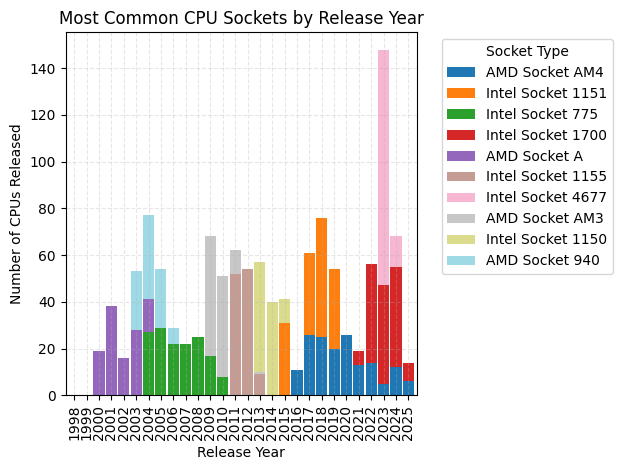

In [31]:
# Step 1: Extract the release year
df_cpu['release_year'] = pd.to_datetime(df_cpu['released'], errors='coerce').dt.year

# Step 2: Group and count socket usage per year
socket_counts = df_cpu.groupby(['release_year', 'socket']).size().unstack(fill_value=0)

# Optional: filter out rare sockets
top_sockets = socket_counts.sum().sort_values(ascending=False).head(10).index
socket_counts_top = socket_counts[top_sockets]

# Step 3: Plot
plt.figure(figsize=(14, 7))
socket_counts_top.plot(kind='bar', stacked=True, colormap='tab20', width=0.9)

plt.title('Most Common CPU Sockets by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of CPUs Released')
plt.legend(title='Socket Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

<Figure size 1400x700 with 0 Axes>

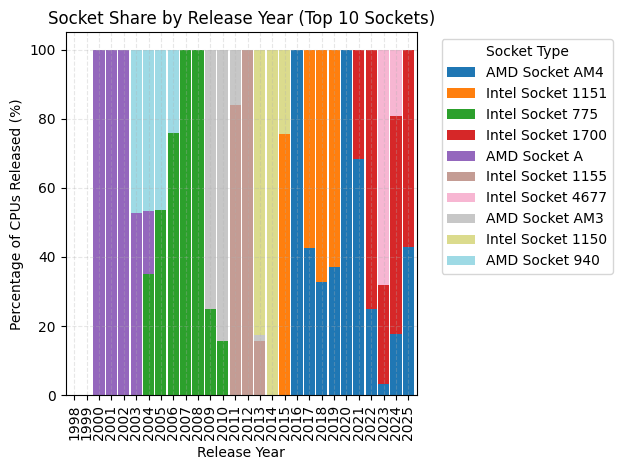

In [32]:
# Step 1: Extract release year
df_cpu['release_year'] = pd.to_datetime(df_cpu['released'], errors='coerce').dt.year

# Step 2: Group and count socket usage per year
socket_counts = df_cpu.groupby(['release_year', 'socket']).size().unstack(fill_value=0)

# Step 3: Filter top N sockets (optional, for cleaner plot)
top_sockets = socket_counts.sum().sort_values(ascending=False).head(10).index
socket_counts_top = socket_counts[top_sockets]

# Step 4: Normalize to percentage (row-wise)
socket_percentages = socket_counts_top.div(socket_counts_top.sum(axis=1), axis=0) * 100

# Step 5: Plot
plt.figure(figsize=(14, 7))
socket_percentages.plot(kind='bar', stacked=True, colormap='tab20', width=0.9)

plt.title('Socket Share by Release Year (Top 10 Sockets)')
plt.xlabel('Release Year')
plt.ylabel('Percentage of CPUs Released (%)')
plt.legend(title='Socket Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [35]:
print("We can see that some years only AMD or only Intel release cpus:")
print("Intel used the “tick‑tock” model for many years: one generation introducing new microarchitecture (“tock”), another refining the process node (“tick”) roughly every 12–18 months. That suggests a roughly yearly cadence for new or refreshed CPUs AMD has shown a pattern of releasing new generations of Ryzen / EPYC / Threadripper at roughly 1‑2 year intervals. For example: Ryzen 1000 (Zen) in 2017 → Ryzen 2000 (Zen+) in 2018 → Ryzen 3000 (Zen 2) in 2019 → Ryzen 5000 (Zen 3) in 2020.")
print("AMD has shown a pattern of releasing new generations of Ryzen / EPYC / Threadripper at roughly 1‑2 year intervals.")

We can see that some years only AMD or only Intel release cpus:
Intel used the “tick‑tock” model for many years: one generation introducing new microarchitecture (“tock”), another refining the process node (“tick”) roughly every 12–18 months. That suggests a roughly yearly cadence for new or refreshed CPUs AMD has shown a pattern of releasing new generations of Ryzen / EPYC / Threadripper at roughly 1‑2 year intervals. For example: Ryzen 1000 (Zen) in 2017 → Ryzen 2000 (Zen+) in 2018 → Ryzen 3000 (Zen 2) in 2019 → Ryzen 5000 (Zen 3) in 2020.
AMD has shown a pattern of releasing new generations of Ryzen / EPYC / Threadripper at roughly 1‑2 year intervals.


AMD Socket AM4 : https://fr.wikipedia.org/wiki/Socket_AM4 -> FC PGA

Intel Socket 1700 : https://fr.wikipedia.org/wiki/LGA_1700 -> FC LGA

Intel Socket 4677 : https://fr.wikipedia.org/wiki/LGA_4677 -> FC LGA

Intel Socket 1151 : https://fr.wikipedia.org/wiki/LGA_1151 -> FC LGA

FC BGA for laptops